# Sonoran Desert: CMIP6 projections
#### Approximation groundwater recharge in 2075
Evaporation in 2025, 2050, 2075 and 2100  for the climate scenarios SSP1-2.6, SSP2-4.5 and SSP5-8.5. The camel that is used for this notebook is: hysets_09488650

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import matplotlib.pyplot as plt
from cartopy import crs
from cartopy import feature as cfeature
import fiona
import shapely.geometry
from pyproj import Geod
from rich import print
import pandas as pd
import xarray as xr

import ewatercycle.forcing
import ewatercycle.models
import ewatercycle.parameter_sets

### Setting up the model: SSP1-2.6
Location of the groundwater recharge: Gila river near Yuma.

In [2]:
station_latitude = [32.76336494699427, 32.88909499784028, 32.684089485789755, 32.865669088682274, 32.719162360122446, 32.828650757990125, 32.756881878799334, 32.82063561463508, 32.60777730703933, 32.67058677793268, 32.94848416830013]
station_longitude = [-114.55114003114731, -114.5017866074773, -114.51809096391581, -113.9776363724262, -114.07727215815218, -113.85359656233821, -114.01646418905023, -113.60895076390092,  -114.10631164360657, -113.76005959016287, -113.35280271756335]

Loading the parameter set and forcing set. Setting up the PCR-GlobWB model. 

In [3]:
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory= "/data/shared/parameter-sets/pcrglobwb_global",
    config="./pcrglobwb_sonoran_ERA5_05min.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)
#print(parameter_set)

In [4]:
forcing126 = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/emol/forcing/sonoran_desert_CMIP_SSP126_75/work/diagnostic/script",
)
#print(forcing)

In [5]:
pcrglob126 = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set,
    forcing=forcing126
)
#print(pcrglob)

Years for which PCR-GlobWB needs to simulate the approximation; 2025, 2050, 2075 and 2100.

In [6]:
#start_time = "2025-01-01T00:00:00Z"
#end_time = "2025-12-31T00:00:00Z"

cfg_file126, cfg_dir126 = pcrglob126.setup(
    start_time="2075-01-01T00:00:00Z",
    end_time="2075-12-31T00:00:00Z",
    max_spinups_in_years=0
)
cfg_file126, cfg_dir126

('/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250109_194444/pcrglobwb_ewatercycle.ini',
 '/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250109_194444')

In [7]:
pcrglob126.initialize(cfg_file126)

In [8]:
time126 = pd.date_range(pcrglob126.start_time_as_isostr, pcrglob126.end_time_as_isostr)
timeseries126 = pd.DataFrame(
    index=pd.Index(time126, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

recharge126 = pd.DataFrame(
    index=pd.Index(time126, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

discharge126 = pd.DataFrame(
    index=pd.Index(time126, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

In [10]:
while pcrglob126.time < pcrglob126.end_time:
    pcrglob126.update()

    # Track discharge for all station locations
    time = pcrglob126.time_as_isostr  # Current time as ISO string
    for i in range(len(station_latitude)):
        
        discharge_at_station126 = pcrglob126.get_value_at_coords(
            "discharge", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        precipitation_at_station126 = pcrglob126.get_value_at_coords(
            "precipitation", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        landsurface_at_station126 = pcrglob126.get_value_at_coords(
            "land_surface_runoff", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )
    
        evaporation_at_station126 = pcrglob126.get_value_at_coords(
            "total_evaporation", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        recharge_at_station126 = pcrglob126.get_value_at_coords(
            "groundwater_recharge", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        abstraction_at_station126 = pcrglob126.get_value_at_coords(
            "total_groundwater_abstraction", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )
        station_key = f"PCRGlobWB: Station {i+1}"  
        if station_key not in timeseries126:
            timeseries126[station_key] = {}

        if station_key not in recharge126:
            recharge126[station_key] = {}
        
        if station_key not in discharge126:
            discharge126[station_key] = {}
        
        # Store the discharge value for the current time
        timeseries126[station_key][time] = precipitation_at_station126[0] + landsurface_at_station126[0] - evaporation_at_station126[0] - abstraction_at_station126[0] 
        recharge126[station_key][time] = recharge_at_station126[0]
        discharge126[station_key][time] = discharge_at_station126[0]
    #print(time126,end='\r')  # "\r" clears the output before printing the next timestamp

<Axes: title={'center': 'Discharge'}, xlabel='time', ylabel='Discharge [mm/day]'>

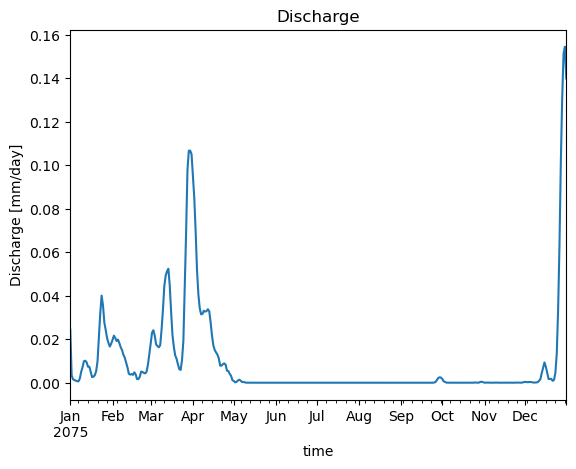

In [36]:
Q126 = pd.DataFrame(discharge126)
Q126['Discharge'] = Q126.mean(axis=1) * 86400 * 1000 / (160000*10**6)
Q126['Discharge'].plot(title='Discharge', ylabel='Discharge [mm/day]')

<Axes: title={'center': 'Approximation Groundwater Recharge'}, xlabel='time', ylabel='Recharge [mm/day]'>

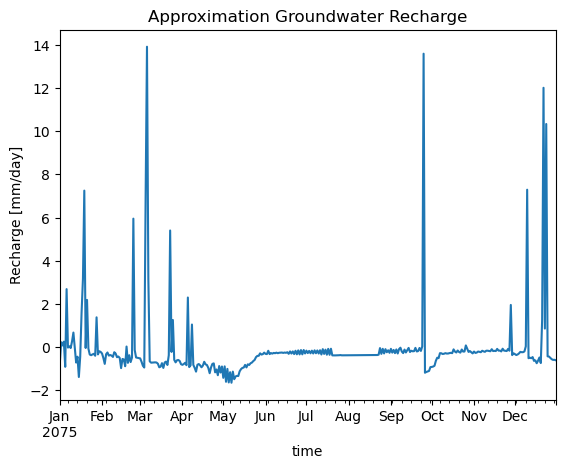

In [37]:
approx126 = pd.DataFrame(timeseries126)
approx126['Approximation Groundwater Recharge'] = approx126.mean(axis=1)*1000 - Q126['Discharge']
approx126['Approximation Groundwater Recharge'].plot(title='Approximation Groundwater Recharge', ylabel = 'Recharge [mm/day]')

<Axes: title={'center': 'PCR-GlobWB Groundwater Recharge (2025)'}, xlabel='time', ylabel='Recharge [mm/day]'>

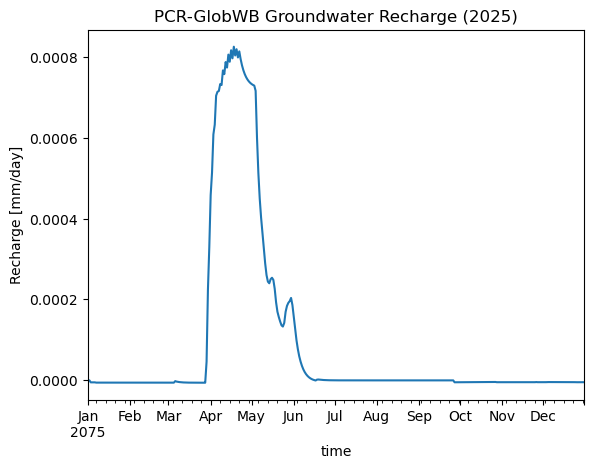

In [44]:
recharge126 = pd.DataFrame(recharge126)
recharge126['Groundwater Recharge'] = recharge126.mean(axis=1)*1000 
recharge126['Groundwater Recharge'].plot(title='PCR-GlobWB Groundwater Recharge (2025)', ylabel = 'Recharge [mm/day]')

Comparing the approximation with the groundwater recharge that is simulated with PCR-GlobWB.

In [ ]:
plt.plot(recharge126*1000, label="PCR-GlobWB Recharge", color="darkblue")
plt.plot(timeseries126*1000, label="Approximated Recharge", color="orange")
plt.title("PCR-GlobWB vs approximated groundwater recharge (SSP1-2.6)")
plt.ylabel("Groundwater recharge [mm/day]")
plt.xlabel("Time")
plt.xticks(rotation=30, ha='right')
plt.legend();

### Now for SSP4-6.0
First, set up the forcing that will be used in the model.

In [13]:
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory= "/data/shared/parameter-sets/pcrglobwb_global",
    config="./pcrglobwb_sonoran_ERA5_05min.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)

In [14]:
forcing245 = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/emol/forcing/sonoran_desert_CMIP_SSP245_75/work/diagnostic/script",
)

In [15]:
pcrglob245 = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set,
    forcing=forcing245
)

In [16]:
#start_time = "2025-01-01T00:00:00Z"
#end_time = "2025-12-31T00:00:00Z"

cfg_file245, cfg_dir245 = pcrglob245.setup(
    start_time="2075-01-01T00:00:00Z", 
    end_time="2075-12-31T00:00:00Z",
    max_spinups_in_years=0
)
cfg_file245, cfg_dir245

('/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250109_200512/pcrglobwb_ewatercycle.ini',
 '/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250109_200512')

In [17]:
pcrglob245.initialize(cfg_file245)

In [18]:
time245 = pd.date_range(pcrglob245.start_time_as_isostr, pcrglob245.end_time_as_isostr)
timeseries245 = pd.DataFrame(
    index=pd.Index(time245, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)
recharge245 = pd.DataFrame(
    index=pd.Index(time245, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

discharge245 = pd.DataFrame(
    index=pd.Index(time245, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

In [19]:
while pcrglob245.time < pcrglob245.end_time:
    pcrglob245.update()

    # Track discharge for all station locations
    time = pcrglob245.time_as_isostr  # Current time as ISO string
    for i in range(len(station_latitude)):
        
        discharge_at_station245 = pcrglob245.get_value_at_coords(
            "discharge", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        precipitation_at_station245 = pcrglob245.get_value_at_coords(
            "precipitation", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        landsurface_at_station245 = pcrglob245.get_value_at_coords(
            "land_surface_runoff", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )
    
        evaporation_at_station245 = pcrglob245.get_value_at_coords(
            "total_evaporation", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        recharge_at_station245 = pcrglob245.get_value_at_coords(
            "groundwater_recharge", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        abstraction_at_station245 = pcrglob245.get_value_at_coords(
            "total_groundwater_abstraction", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )
        station_key = f"PCRGlobWB: Station {i+1}"  
        if station_key not in timeseries245:
            timeseries245[station_key] = {}

        if station_key not in recharge245:
            recharge245[station_key] = {}
        
        if station_key not in discharge245:
            discharge245[station_key] = {}
        
        # Store the discharge value for the current time
        timeseries245[station_key][time] = precipitation_at_station245[0] + landsurface_at_station245[0] - evaporation_at_station245[0] - abstraction_at_station245[0] 
        recharge245[station_key][time] = recharge_at_station245[0]
        discharge245[station_key][time] = discharge_at_station245[0]

    
    #print(time245,end='\r')  # "\r" clears the output before printing the next timestamp

<Axes: title={'center': 'Discharge'}, xlabel='time', ylabel='Discharge [mm/day]'>

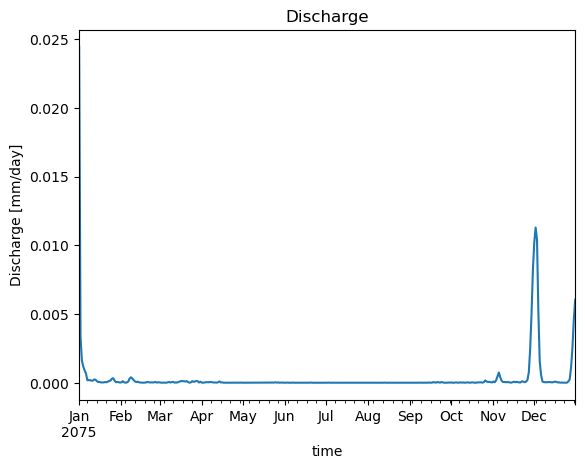

In [38]:
Q245 = pd.DataFrame(discharge245)
Q245['Discharge'] = Q245.mean(axis=1) * 86400 * 1000 / (160000*10**6)
Q245['Discharge'].plot(title='Discharge', ylabel='Discharge [mm/day]')

<Axes: title={'center': 'Approximation Groundwater Recharge'}, xlabel='time', ylabel='Recharge [mm/day]'>

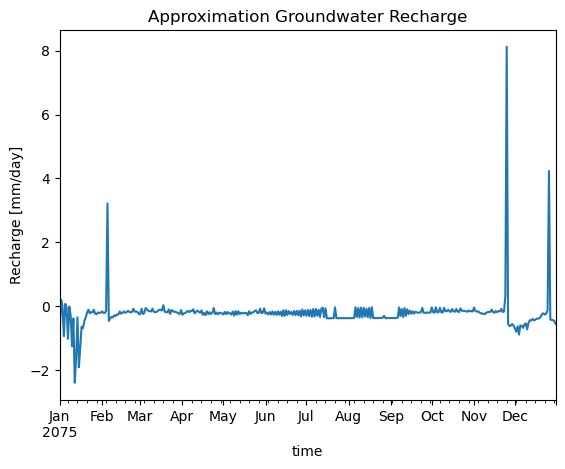

In [39]:
approx245 = pd.DataFrame(timeseries245)
approx245['Approximation Groundwater Recharge'] = approx245.mean(axis=1)*1000 - Q245['Discharge']
approx245['Approximation Groundwater Recharge'].plot(title='Approximation Groundwater Recharge', ylabel = 'Recharge [mm/day]')

<Axes: title={'center': 'PCR-GlobWB Groundwater Recharge (2025)'}, xlabel='time', ylabel='Recharge [mm/day]'>

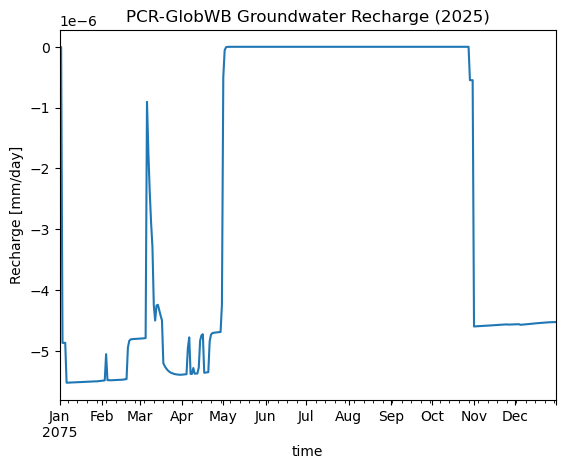

In [45]:
recharge245 = pd.DataFrame(recharge245)
recharge245['Groundwater Recharge'] = recharge245.mean(axis=1)*1000 
recharge245['Groundwater Recharge'].plot(title='PCR-GlobWB Groundwater Recharge (2025)', ylabel = 'Recharge [mm/day]')

Comparing the approximation with the groundwater recharge that is simulated with PCR-GlobWB.

In [ ]:
plt.plot(recharge245*1000, label="PCR-GlobWB Recharge", color="darkblue")
plt.plot(timeseries245*1000, label="Approximated Recharge", color="orange")
plt.title("PCR-GlobWB vs approximated groundwater recharge (SSP2-4.5)")
plt.ylabel("Groundwater recharge [mm/day]")
plt.xlabel("Time")
plt.xticks(rotation=30, ha='right')
plt.legend();

### Now for SSP5-8.5
First, set up the forcing.

In [22]:
parameter_set = ewatercycle.parameter_sets.ParameterSet(
    name="custom_parameter_set",
    directory= "/data/shared/parameter-sets/pcrglobwb_global",
    config="./pcrglobwb_sonoran_ERA5_05min.ini",
    target_model="pcrglobwb",
    supported_model_versions={"setters"},
)
#print(parameter_set)

In [23]:
forcing585 = ewatercycle.forcing.sources["PCRGlobWBForcing"].load(
    directory="/home/emol/forcing/sonoran_desert_CMIP_SSP585_75/work/diagnostic/script",
)
#print(forcing)

In [24]:
pcrglob585 = ewatercycle.models.PCRGlobWB(
    parameter_set=parameter_set,
    forcing=forcing585
)

In [25]:
#start_time = "2025-01-01T00:00:00Z"
#end_time = "2025-12-31T00:00:00Z"

cfg_file585, cfg_dir585 = pcrglob585.setup(
    start_time="2075-01-01T00:00:00Z",
    end_time="2075-12-31T00:00:00Z",
    max_spinups_in_years=0
)
cfg_file585, cfg_dir585

('/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250109_202846/pcrglobwb_ewatercycle.ini',
 '/home/emol/repos/projects/book/thesis_projects/BSc/2024_Q2_ElineMol_CEG/Deliverables/pcrglobwb_20250109_202846')

In [26]:
pcrglob585.initialize(cfg_file585)

In [27]:
time585 = pd.date_range(pcrglob585.start_time_as_isostr, pcrglob585.end_time_as_isostr)
timeseries585 = pd.DataFrame(
    index=pd.Index(time585, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

recharge585 =  pd.DataFrame(
    index=pd.Index(time585, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

discharge585 = pd.DataFrame(
    index=pd.Index(time585, name="time"), columns=["PCRGlobWB: Sonoran Desert"]
)

In [28]:
while pcrglob585.time < pcrglob585.end_time:
    pcrglob585.update()

    # Track discharge for all station locations
    time = pcrglob585.time_as_isostr  # Current time as ISO string
    for i in range(len(station_latitude)):
        
        discharge_at_station585 = pcrglob585.get_value_at_coords(
            "discharge", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        precipitation_at_station585 = pcrglob585.get_value_at_coords(
            "precipitation", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        landsurface_at_station585 = pcrglob585.get_value_at_coords(
            "land_surface_runoff", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )
    
        evaporation_at_station585 = pcrglob585.get_value_at_coords(
            "total_evaporation", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        recharge_at_station585 = pcrglob585.get_value_at_coords(
            "groundwater_recharge", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )

        abstraction_at_station585 = pcrglob585.get_value_at_coords(
            "total_groundwater_abstraction", lat=[station_latitude[i]], lon=[station_longitude[i]]
        )
        station_key = f"PCRGlobWB: Station {i+1}"  
        if station_key not in timeseries585:
            timeseries585[station_key] = {}

        if station_key not in recharge585:
            recharge585[station_key] = {}
        
        if station_key not in discharge585:
            discharge585[station_key] = {}
        
        # Store the discharge value for the current time
        timeseries585[station_key][time] = precipitation_at_station585[0] + landsurface_at_station585[0] - evaporation_at_station585[0] - abstraction_at_station585[0] 
        recharge585[station_key][time] = recharge_at_station585[0]
        discharge585[station_key][time] = discharge_at_station585[0]

    # Show progress
    #print(time585,end='\r')  # "\r" clears the output before printing the next timestamp


<Axes: title={'center': 'Discharge'}, xlabel='time', ylabel='Discharge [mm/day]'>

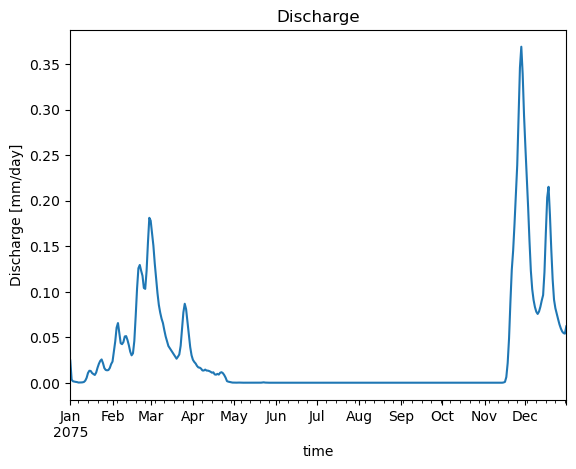

In [40]:
Q585 = pd.DataFrame(discharge585)
Q585['Discharge'] = Q585.mean(axis=1) * 86400 * 1000 / (160000*10**6)
Q585['Discharge'].plot(title='Discharge', ylabel='Discharge [mm/day]')

<Axes: title={'center': 'Approximation Groundwater Recharge'}, xlabel='time', ylabel='Recharge [mm/day]'>

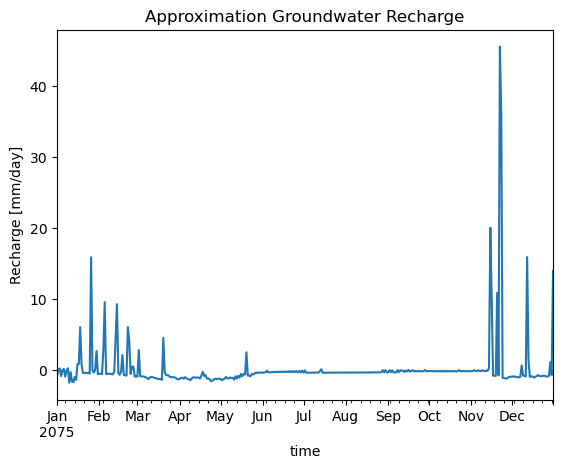

In [41]:
approx585 = pd.DataFrame(timeseries585)
approx585['Approximation Groundwater Recharge'] = approx585.mean(axis=1)*1000 - Q585['Discharge']
approx585['Approximation Groundwater Recharge'].plot(title='Approximation Groundwater Recharge', ylabel = 'Recharge [mm/day]')

<Axes: title={'center': 'PCR-GlobWB Groundwater Recharge (2025)'}, xlabel='time', ylabel='Recharge [mm/day]'>

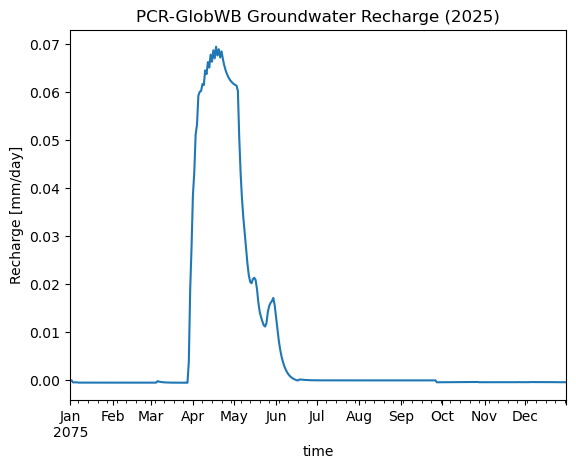

In [46]:
recharge585 = pd.DataFrame(recharge585)
recharge585['Groundwater Recharge'] = recharge126.mean(axis=1)*1000 
recharge585['Groundwater Recharge'].plot(title='PCR-GlobWB Groundwater Recharge (2025)', ylabel = 'Recharge [mm/day]')

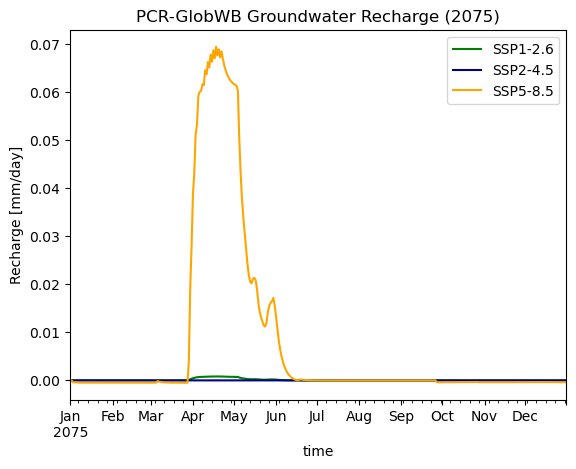

In [49]:
recharge126['Groundwater Recharge'].plot(title='PCR-GlobWB Groundwater Recharge (2075)', ylabel = 'Recharge [mm/day]', label="SSP1-2.6", color="green")
recharge245['Groundwater Recharge'].plot(title='PCR-GlobWB Groundwater Recharge (2075)', ylabel = 'Recharge [mm/day]', label="SSP2-4.5", color="darkblue")
recharge585['Groundwater Recharge'].plot(title='PCR-GlobWB Groundwater Recharge (2075)', ylabel = 'Recharge [mm/day]', label="SSP5-8.5", color="orange")
plt.legend();

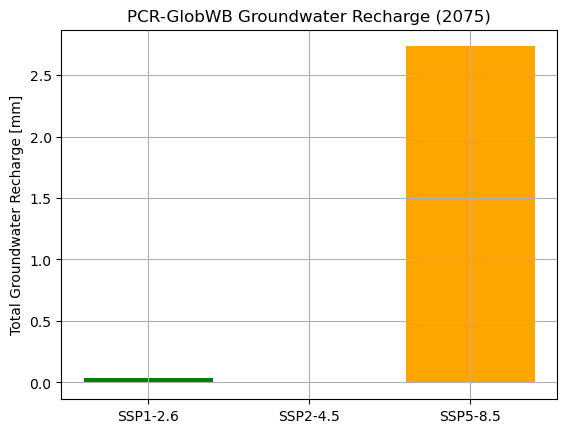

In [50]:
t_126 = recharge126.sum() 
t_245 = recharge245.sum() 
t_585 = recharge585.sum() 

categories = ["SSP1-2.6", "SSP2-4.5", "SSP5-8.5"]
totals = [t_126, t_245, t_585]
colors = ["green", "darkblue", "orange"]

for i in range(len(totals)):
    plt.bar(categories[i], totals[i], color=colors[i])

plt.title("PCR-GlobWB Groundwater Recharge (2075)")
plt.ylabel("Total Groundwater Recharge [mm]")
plt.grid()

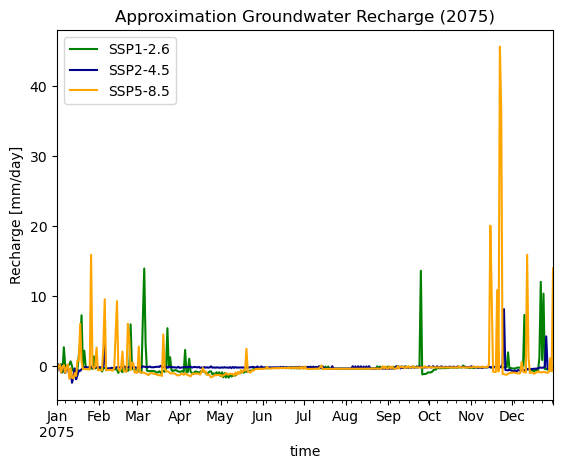

In [42]:
approx126['Approximation Groundwater Recharge'].plot(title='Approximation Groundwater Recharge (2075)', ylabel = 'Recharge [mm/day]', label="SSP1-2.6", color="green")
approx245['Approximation Groundwater Recharge'].plot(title='Approximation Groundwater Recharge (2075)', ylabel = 'Recharge [mm/day]', label="SSP2-4.5", color="darkblue")
approx585['Approximation Groundwater Recharge'].plot(title='Approximation Groundwater Recharge (2075)', ylabel = 'Recharge [mm/day]', label="SSP5-8.5", color="orange")
plt.legend()

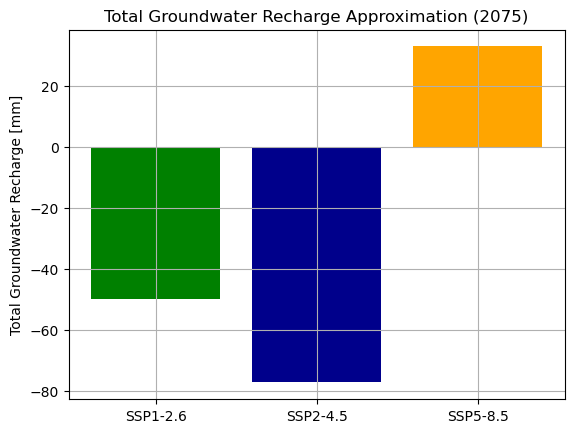

In [43]:
total_126 = approx126.sum() 
total_245 = approx245.sum() 
total_585 = approx585.sum() 

categories = ["SSP1-2.6", "SSP2-4.5", "SSP5-8.5"]
totals = [total_126, total_245, total_585]
colors = ["green", "darkblue", "orange"]

for i in range(len(totals)):
    plt.bar(categories[i], totals[i], color=colors[i])

plt.title("Total Groundwater Recharge Approximation (2075)")
plt.ylabel("Total Groundwater Recharge [mm]")
plt.grid()

Comparing the approximation with the groundwater recharge that is simulated with PCR-GlobWB.

In [ ]:
plt.plot(recharge585*1000, label="PCR-GlobWB Recharge", color="darkblue")
plt.plot(timeseries585*1000, label="Approximated Recharge", color="orange")
plt.title("PCR-GlobWB vs approximated groundwater recharge (SSP2-4.5)")
plt.ylabel("Groundwater recharge [mm/day]")
plt.xlabel("Time")
plt.xticks(rotation=30, ha='right')
plt.legend();

### Plotting the timeseries

In [ ]:
plt.plot(timeseries126*1000, label="SSP1-2.6", color="green")
plt.plot(timeseries245*1000, label="SSP2-4.5", color="darkblue")
plt.plot(timeseries585*1000, label="SSP5-8.5", color="orange")

plt.title("Approximation Groundwater Recharge (2075)")
plt.xlabel("Time")
plt.ylabel("Groundwater Recharge [mm/day]")
plt.xticks(rotation=30, ha='right')
plt.legend(loc=2);

In [ ]:
total_126 = timeseries126.sum() * 1000 
total_245 = timeseries245.sum() * 1000 
total_585 = timeseries585.sum() * 1000 

categories = ["SSP1-2.6", "SSP2-4.5", "SSP5-8.5"]
totals = [total_126, total_245, total_585]
colors = ["green", "darkblue", "orange"]

for i in range(len(totals)):
    plt.bar(categories[i], totals[i], color=colors[i])

plt.title("Total Groundwater Recharge Approximation (2075)")
plt.ylabel("Total Groundwater Recharge [mm]")
plt.grid()

In [ ]:
pcrglob126.finalize()
pcrglob245.finalize()
pcrglob585.finalize()